# Data Cleaning and EDA #
The script has gathered up to 100 reviews per user for almost 300 users. Time to make sure all the data is present

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# File path to the consolidated data
path = '../data/interim/consolidated_data.csv'

In [3]:
df = pd.read_csv(path)
df.head()

,title,author,avg_rating,user_rating,cover_url,user_id
0,Harry Potter and the Sorcerer's Stone (Harry P...,NaN,4.47,5,https://i.gr-assets.com/images/S/compressed.ph...,1
1,"The Hunger Games (The Hunger Games, #1)",NaN,4.33,5,https://i.gr-assets.com/images/S/compressed.ph...,1
2,To Kill a Mockingbird,NaN,4.26,5,https://i.gr-assets.com/images/S/compressed.ph...,1
3,The Great Gatsby,NaN,3.93,4,https://i.gr-assets.com/images/S/compressed.ph...,1
4,1984,NaN,4.19,5,https://i.gr-assets.com/images/S/compressed.ph...,1


In [4]:
df.shape

(29530, 6)

In [5]:
df['title'].nunique()

6334

In [6]:
df['cover_url'].nunique()

9872

In [7]:
df.isna().sum()

title              0
author         29530
avg_rating         0
user_rating        0
cover_url          0
user_id            0
dtype: int64

In [8]:
df.user_id.unique().dtype

dtype('int64')

In [9]:
non_integers = df[pd.to_numeric(df['user_id'], errors='coerce').isna()]
print(non_integers)

Empty DataFrame
Columns: [title, author, avg_rating, user_rating, cover_url, user_id]
Index: []


### First Impressions ###
There are 29,530 reviews here, but only 6,334 unique books. This isn't a huge surprise, since I sorted each user's "read" shelf by most-reviewed and scraped the top 100. I'm actually glad to see this much variety. This should mean that I have legitimate recommendation power but that I don't recommend very obscure or unpopular books. There are more unique cover URLs due to different editions existing for many of the books.

The script also failed to gather the "author" column for some reason. This information would be nice to have but ultimately isn't worth the time to re-run the script. If this project were going into production, I'd gather far more than title, author, and rating anyways. I'll drop the author column for now.

In [10]:
try:
    df = df.drop('author', axis = 1)
except:
    pass
df.head()

,title,avg_rating,user_rating,cover_url,user_id
0,Harry Potter and the Sorcerer's Stone (Harry P...,4.47,5,https://i.gr-assets.com/images/S/compressed.ph...,1
1,"The Hunger Games (The Hunger Games, #1)",4.33,5,https://i.gr-assets.com/images/S/compressed.ph...,1
2,To Kill a Mockingbird,4.26,5,https://i.gr-assets.com/images/S/compressed.ph...,1
3,The Great Gatsby,3.93,4,https://i.gr-assets.com/images/S/compressed.ph...,1
4,1984,4.19,5,https://i.gr-assets.com/images/S/compressed.ph...,1


# SQL Database Exploration #
Now I want to check out the relational database I made from the data

In [11]:
database_path = os.path.abspath(
            os.path.join(
                os.pardir,
                'data',
                'processed',
                'books.db'
                )
            )

conn = sqlite3.connect(database_path)

In [12]:
cur = conn.cursor()
cur.execute('SELECT * FROM Ratings LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, 1, 5, 4.47)
(10160415, 1, 0, 4.47)
(1019021, 1, 5, 4.47)
(10367112, 1, 4, 4.47)
(104823, 1, 4, 4.47)
(1053760, 1, 5, 4.47)
(10553671, 1, 5, 4.47)
(106638288, 1, 3, 4.47)
(1072582, 1, 5, 4.47)
(10915830, 1, 5, 4.47)


In [13]:
cur = conn.cursor()
cur.execute('SELECT * FROM Books LIMIT 10')
results = cur.fetchall()

for row in results:
    print(row)

(1, "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1474154022l/3._SY75_.jpg')
(2, 'The Hunger Games (The Hunger Games, #1)', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1586722975l/2767052._SX50_.jpg')
(3, 'To Kill a Mockingbird', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1553383690l/2657._SY75_.jpg')
(4, 'The Great Gatsby', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1490528560l/4671._SY75_.jpg')
(5, '1984', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1348990566l/5470._SY75_.jpg')
(6, 'Pride and Prejudice', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1622158493l/1893._SX50_.jpg')
(7, 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)', 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1630547330l/5._SY75_.jpg')
(8, 'The Hobbit (The Lord 

In [14]:
cur.execute('SELECT COUNT(*) FROM Books')
book_count = cur.fetchone()
print(book_count)

(9909,)


In [15]:
cur.execute('SELECT COUNT(*) FROM Users')
user_count = cur.fetchone()
print(user_count)

(298,)


In [16]:
for row in conn.execute('PRAGMA table_info(Ratings)'):
    print(row)

(0, 'user_id', 'INTEGER', 0, None, 0)
(1, 'book_id', 'INTEGER', 0, None, 0)
(2, 'user_rating', 'INTEGER', 0, None, 0)
(3, 'avg_rating', 'REAL', 0, None, 0)


### Database Assessment ###
The database is correctly built with all books, users, and ratings accounted for! There are 9902 unique combinations of book title and cover URL. While I'd like to go through and merge all unique editions into a single entry, I don't expect it would be worth the effort for the purposes of this project.

## EDA ##
Now I want to take a look at the distributions of books and ratings.

In [17]:
query = '''
SELECT b.title, AVG(r.avg_rating) as avg_rating, COUNT(r.user_rating) as votes
FROM Books b
JOIN Ratings r ON b.book_id = r.book_id
GROUP BY b.title
'''
books_avg_ratings_df = pd.read_sql_query(query, conn)

In [18]:
books_avg_ratings_df.sort_values(by = ['votes', 'avg_rating'], ascending = [False, False]).head(10)

,title,avg_rating,votes
4809,"The Hunger Games (The Hunger Games, #1)",4.33,177
1970,Harry Potter and the Sorcerer's Stone (Harry P...,4.47,173
1945,Harry Potter and the Chamber of Secrets (Harry...,4.43,160
4699,The Great Gatsby,3.93,159
5788,To Kill a Mockingbird,4.26,155
1967,Harry Potter and the Prisoner of Azkaban (Harr...,4.58,154
1956,Harry Potter and the Goblet of Fire (Harry Pot...,4.56,153
1953,Harry Potter and the Deathly Hallows (Harry Po...,4.62,146
873,"Catching Fire (The Hunger Games, #2)",4.32,146
1960,Harry Potter and the Order of the Phoenix (Har...,4.50,144


The most popular book appears to be the first Hunger Games book, with 177 reviews among 298 users. The first Harry Potter book is right behind with 173 reviews. I'm very surprised that Harry Potter and the Half-Blood Prince is so low compared to the rest of the books in the series.

In [19]:
ratings_df = pd.read_sql_query('SELECT * FROM Ratings', conn)
ratings_df.head()

,user_id,book_id,user_rating,avg_rating
0,1,1,5,4.47
1,10160415,1,0,4.47
2,1019021,1,5,4.47
3,10367112,1,4,4.47
4,104823,1,4,4.47


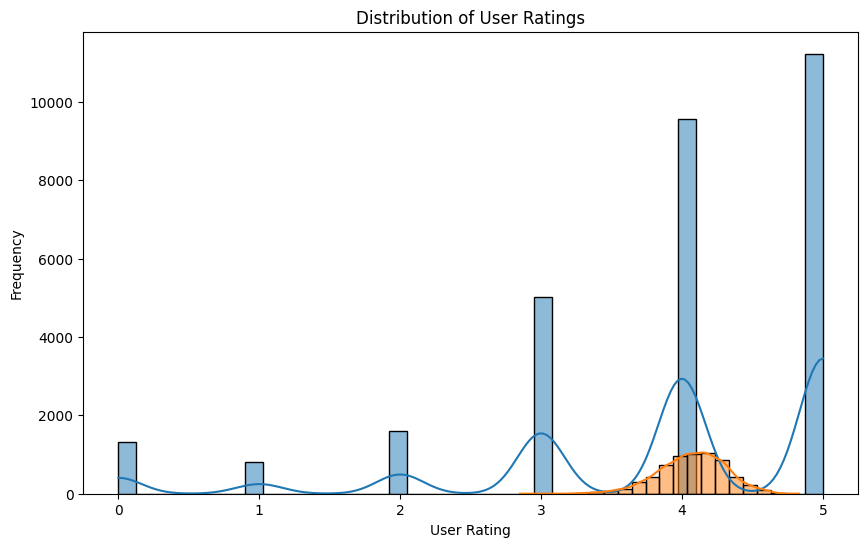

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['user_rating'], kde = True)
sns.histplot(books_avg_ratings_df['avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

The above histograms show the distribution of user ratings in blue and the distribution of average ratings in orange. It is not surprising that the most popular users would give the most popular books a high rating generally. I am a little surprised that these users give out so many 5-star reviews. While it is very subjective, many Goodreads users adhere to the same rating scale, where a 5-star rating is reserved for the user's favorite books of all time. But I suppose that popular, well-reviewed books are exactly that for a reason. The median book in this dataset has an average rating of just over 4 stars. Ths distribution of average ratings has a longer tail on the left, which makes sense due to the cap at 5 stars. I'm a little surprised to see that some of the books on this list managed to be popular enough but also average fewer than 3 stars.

In [21]:
query = '''
SELECT user_id, AVG(user_rating) as user_avg_rating
FROM Ratings r
GROUP BY user_id
'''
user_avg_ratings_df = pd.read_sql_query(query, conn)

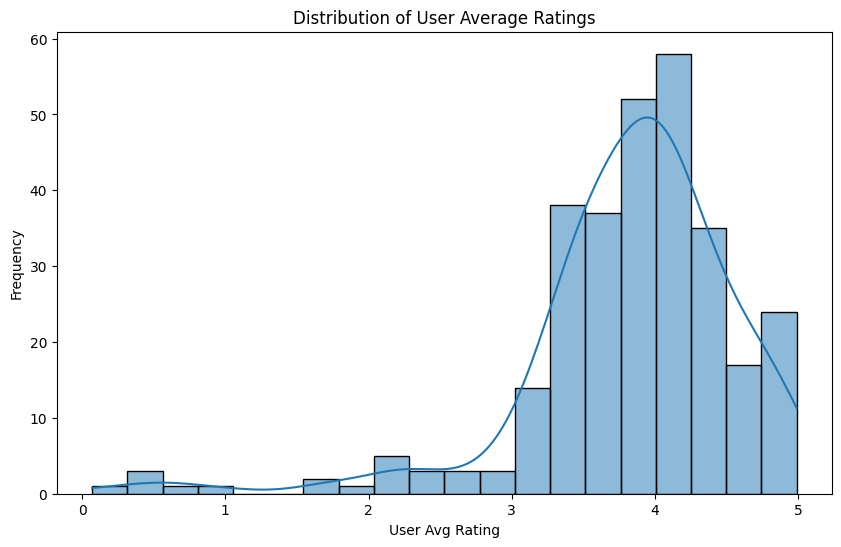

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings_df['user_avg_rating'], kde = True, bins = 20)
plt.title('Distribution of User Average Ratings')
plt.xlabel('User Avg Rating')
plt.ylabel('Frequency')
plt.show()

This histogram plot shows the distribution of each user's average rating. Some users clearly love the popular books, giving out an average of almost 5 stars. Many users are clustered around the 4-star average rating. Some users, on the other hand, seem to be haters and give out generally very low scores. I'll check those users out.

In [23]:
query = '''
SELECT user_id, SUM(user_rating == 0) AS zero_star, SUM(user_rating == 1) AS one_star, SUM(user_rating == 2) AS two_star,
SUM(user_rating == 3) AS three_star, SUM(user_rating == 4) AS four_star,
SUM(user_rating == 5) AS five_star, 
AVG(user_rating) AS user_avg
FROM Ratings r
GROUP BY user_id
HAVING AVG(user_rating) < 3
'''

low_ratings_df = pd.read_sql_query(query, conn)

In [24]:
low_ratings_df

,user_id,zero_star,one_star,two_star,three_star,four_star,five_star,user_avg
0,914795,0,14,64,13,7,2,2.190000
1,1005037,39,5,6,11,19,20,2.260000
2,1113032,43,0,1,21,23,12,2.170000
3,1151637,53,2,6,11,20,8,1.670000
4,1162953,8,2,25,47,16,2,2.670000
5,2164884,18,3,22,39,18,0,2.360000
6,3258178,0,11,32,36,12,9,2.760000
7,3571171,4,8,21,50,14,3,2.710000
8,3734681,86,0,0,3,8,3,0.560000
9,5451550,79,0,1,6,14,0,0.760000


Right away I can see some users rarely rate books, often just logging them as "read" without assigning a score. These are users which I would likely drop from the training data if I refined my model further. As it stands, I'll keep them since I don't have a trememndously large dataset to begin with. I'm more intrigued by the users who score each book but are very stingy with high scores. User 3258178 for instance has no zeros and only 9 fives. They mostly rate books either 2 or 3 stars. 

In [25]:
query = '''
SELECT r.user_id, b.title, r.user_rating, r.avg_rating 
FROM Ratings r
JOIN Books b ON b.book_id = r.book_id
WHERE user_id == 3258178
'''

user_3258178_df = pd.read_sql_query(query, conn)

In [26]:
differenced_df = user_3258178_df.assign(diff = (user_3258178_df['user_rating']) - user_3258178_df['avg_rating'])
differenced_df.sort_values(by = 'diff', ascending = False)

,user_id,title,user_rating,avg_rating,diff
25,3258178,Macbeth,5,3.90,1.10
37,3258178,Fahrenheit 451,5,3.97,1.03
82,3258178,Prince Caspian - Book 2 in the Chronicles of N...,5,3.98,1.02
39,3258178,Animal Farm,5,3.98,1.02
76,3258178,"The Voyage Of The ""Dawn Treader""",5,4.09,0.91
...,...,...,...,...,...
77,3258178,"Along Came a Spider (Alex Cross, #1)",1,4.13,-3.13
17,3258178,Jane Eyre,1,4.15,-3.15
38,3258178,The Shining,1,4.26,-3.26
21,3258178,Pride and Prejudice,1,4.28,-3.28


In [27]:
differenced_df['diff'].loc[differenced_df['diff'] > 0].count()

15

In [28]:
user_avg = np.mean(differenced_df['user_rating'])
goodreads_avg = np.mean(differenced_df['avg_rating'])
diff_avg = np.mean(differenced_df['diff'])
print(f"The User averages a score of {user_avg} stars compared to a Goodreads average of \
{goodreads_avg:0.2f} stars\n for books in the user's library. This is an average differential of \
{diff_avg:0.2f} stars.")

The User averages a score of 2.76 stars compared to a Goodreads average of 4.07 stars
 for books in the user's library. This is an average differential of -1.31 stars.


plt.figure(figsize=(10, 6))
sns.histplot(differenced_df['diff'], kde = True, bins = 25)
plt.axvline(0, 0, 1, color = 'orange')
plt.axvline(-1.31, 0, 1, color = 'red')
plt.title('Distribution of User 3258178 Relative Ratings')
plt.xlabel('Relative Rating (Goodreads Average - User Rating)')
plt.ylabel('Frequency')
plt.show()

This particular user is  particularly strict with their ratings. The user averages a rating of 2.76 stars, which is over a full star less than the average Goodreads rating for the books in their library. They have rated 15 books above the Goodreads average, so I wouldn't consider them a hater. They just tend not to love the most popular books.

User 77805119 doesn't merit much analysis. They seem to treat the ratings as binary, rating most books either 0 or 5 stars. This could be good feedback for a model, equating to either a "yes" or "no" recommendation.

In [29]:
conn.close()

# Conclusion #
This exploration has shown me that the most popular Goodreads users do not have a uniform system for rating books. Many of them use a similar scale : 
* 1 star - I did not like it
* 2 stars - It was fine
* 3 stars - I liked it
* 4 stars - I really liked it

Other users rate very differently. The model will have to account for these variations as it learns how to recommend books based on user similarity scores. Realistically, I'll have to normalize and scale the scores during the feature engineering phase.